## **Imports**

In [163]:
import os
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import uniform

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

## **Paths & Global Variables**

In [164]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"
TARGET_VAR = "survived"
COLINEARITY_THRESHOLD = 0.4

import sys

sys.path.append(ROOT_PATH)

from titanic.config import PROCESSED_DATA_DIR, MODELS_DIR

## **Reading Data**

In [165]:
os.chdir(PROCESSED_DATA_DIR)

X_train = pd.read_parquet("X_train.parquet")
y_train = pd.read_parquet("y_train.parquet")

X_test = pd.read_parquet("X_val.parquet")
y_test = pd.read_parquet("y_val.parquet")

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

<Axes: >

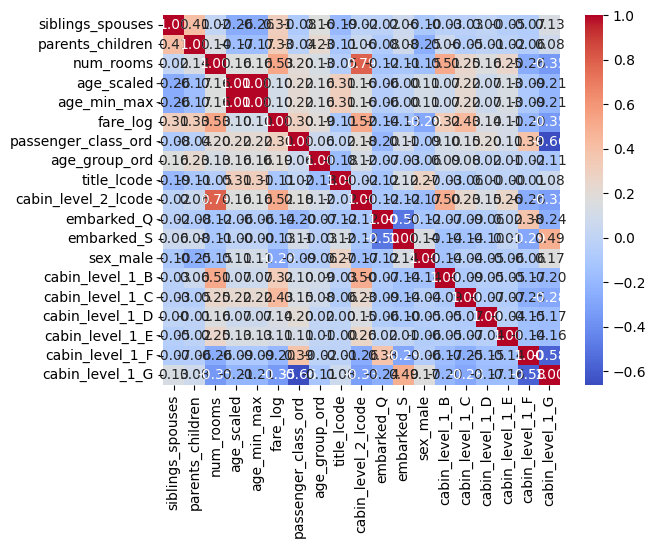

In [166]:
corr_matrix = X_train.corr(method="pearson")
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")

<Axes: >

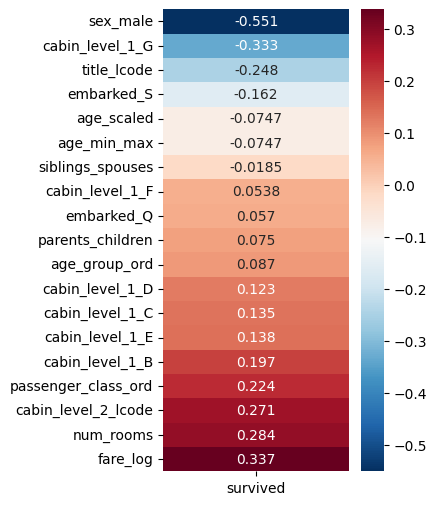

In [167]:
# Features Linearly Related to Log-odds
X_y = pd.concat([X_train, y_train], axis=1)
corr_X_y_matrix = X_y.corr()

# Isolate the column corresponding to `exam_score`
corr_target = corr_X_y_matrix[[TARGET_VAR]].drop(labels=[TARGET_VAR])
corr_target.sort_values(TARGET_VAR, inplace=True)

plt.figure(figsize=(3, 6))
sns.heatmap(corr_target, annot=True, fmt=".3", cmap="RdBu_r")

In [168]:
# Variables with high correlation with each other should be removed (r > 0.75)
corr_target.reset_index(inplace=True)
corr_target.columns = ["feature", "corr_target"]
mcol_df = pd.DataFrame()

# Loop over bottom diagonal of correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):

        # Print variables with high correlation
        if abs(corr_matrix.iloc[i, j]) > COLINEARITY_THRESHOLD:
            var_1 = corr_matrix.columns[i]
            var_2 = corr_matrix.columns[j]
            corr = corr_matrix.iloc[i, j]
            temp_df = pd.DataFrame({"var1": [var_1], "var2": [var_2], "corr": [corr]})
            mcol_df = pd.concat([temp_df, mcol_df])

for var in ["var1", "var2"]:
    mcol_df = pd.merge(
        mcol_df, corr_target, left_on=var, right_on="feature", how="left"
    )
    mcol_df.drop(columns=["feature"], inplace=True)
    mcol_df.rename(columns={"corr_target": f"corr_target_{var[-1]}"}, inplace=True)

mcol_df["col_to_drop"] = mcol_df.apply(
    lambda x: (
        x["var1"] if abs(x["corr_target_1"]) < abs(x["corr_target_2"]) else x["var2"]
    ),
    axis=1,
)
mcol_df

,var1,var2,corr,corr_target_1,corr_target_2,col_to_drop
0,cabin_level_1_G,cabin_level_1_F,-0.582279,-0.332638,0.053818,cabin_level_1_F
1,cabin_level_1_G,embarked_S,0.489291,-0.332638,-0.161777,embarked_S
2,cabin_level_1_G,passenger_class_ord,-0.662381,-0.332638,0.223754,passenger_class_ord
3,cabin_level_1_C,fare_log,0.434336,0.135430,0.337468,cabin_level_1_C
4,cabin_level_1_B,cabin_level_2_lcode,0.497370,0.197149,0.271087,cabin_level_1_B
5,cabin_level_1_B,num_rooms,0.513494,0.197149,0.283692,cabin_level_1_B
6,embarked_S,embarked_Q,-0.499927,-0.161777,0.056954,embarked_Q
7,cabin_level_2_lcode,fare_log,0.515156,0.271087,0.337468,cabin_level_2_lcode
8,cabin_level_2_lcode,num_rooms,0.788851,0.271087,0.283692,cabin_level_2_lcode
9,fare_log,num_rooms,0.529134,0.337468,0.283692,num_rooms


In [169]:
cols_to_reduce = mcol_df["col_to_drop"].unique()

In [170]:
X_high_corr = X_train.drop(columns=cols_to_reduce)
X_high_corr_test = X_test.drop(columns=cols_to_reduce)

X_low_corr = X_train[cols_to_reduce]
X_low_corr_test = X_test[cols_to_reduce]

In [171]:
X_low_corr.columns

Index(['cabin_level_1_F', 'embarked_S', 'passenger_class_ord',
       'cabin_level_1_C', 'cabin_level_1_B', 'embarked_Q',
       'cabin_level_2_lcode', 'num_rooms', 'age_min_max', 'siblings_spouses'],
      dtype='object')

In [172]:
X_high_corr.columns

Index(['parents_children', 'age_scaled', 'fare_log', 'age_group_ord',
       'title_lcode', 'sex_male', 'cabin_level_1_D', 'cabin_level_1_E',
       'cabin_level_1_G'],
      dtype='object')

# **Linear Discriminant Analysis**

In [173]:
# Create LDA model
COMPONENTS = 1
lda = LinearDiscriminantAnalysis(n_components=COMPONENTS)

In [174]:
# Fit the data and create a subspace X_new
X_lda = lda.fit_transform(X_low_corr, y_train.values.ravel())
X_lda.shape

(711, 1)

<Axes: >

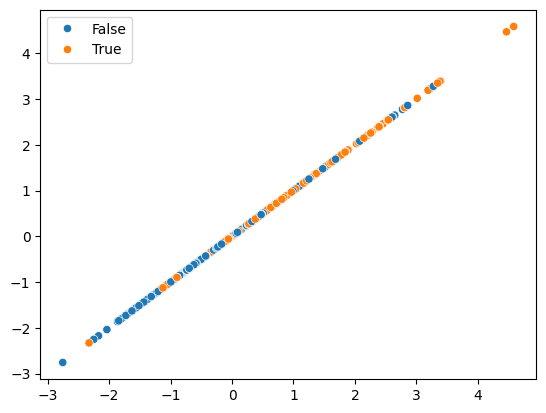

In [175]:
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 0], hue=y_train.values.ravel())

In [176]:
for i in range(COMPONENTS):
    X_low_corr[f'lda_{i+1}'] = X_lda[:, i]

X_low_corr.drop(columns=cols_to_reduce, inplace=True)
X_low_corr.head()

C:\Users\mario\AppData\Local\Temp\ipykernel_25548\3629429575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_low_corr[f'lda_{i+1}'] = X_lda[:, i]
C:\Users\mario\AppData\Local\Temp\ipykernel_25548\3629429575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_low_corr.drop(columns=cols_to_reduce, inplace=True)


,lda_1
passenger_id,
622,0.118138
482,0.324177
528,1.550767
436,3.231767
798,-1.085643


# **Logistic Regression**

## **Model Fitting**

In [177]:
log_reg = LogisticRegression(class_weight="balanced", solver="liblinear")
log_reg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## **Hyperparameter Tuning**

In [178]:
distributions = {"penalty": ["l1", "l2"], "C": uniform(loc=0, scale=100)}

In [179]:
clf = RandomizedSearchCV(log_reg, distributions, n_iter=30, cv=10, scoring="roc_auc")
clf.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': 'balanced',
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'deprecated',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(class_weight='balanced', solver='liblinear'),
 'n_iter': 30,
 'n_jobs': None,
 'param_distributions': {'penalty': ['l1', 'l2'],
  'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x266090b0050>},
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 0}

In [180]:
X_new = pd.merge(
    X_high_corr, X_low_corr, left_index=True, right_index=True,
)
X_new.head()

,parents_children,age_scaled,fare_log,age_group_ord,title_lcode,sex_male,cabin_level_1_D,cabin_level_1_E,cabin_level_1_G,lda_1
passenger_id,,,,,,,,,,
622,0,0.958818,3.980694,1,12,True,True,False,False,0.118138
482,0,0.084755,0.000000,0,12,True,False,False,False,0.324177
528,0,0.936487,5.406181,1,12,True,False,False,False,1.550767
436,2,-1.167801,4.795791,3,9,False,False,False,False,3.231767
798,0,0.123360,2.270403,0,13,False,False,False,True,-1.085643


In [181]:
clf.fit(X_new, y_train.values.ravel())
best_model = clf.best_estimator_
print(best_model)
print(clf.best_params_)

LogisticRegression(C=np.float64(6.536355450990627), class_weight='balanced',
                   penalty='l1', solver='liblinear')
{'C': np.float64(6.536355450990627), 'penalty': 'l1'}


## **Model Testing**

In [182]:
# Transform test data using the same LDA transformation
X_test_lda = lda.transform(X_low_corr_test)

In [183]:
for i in range(COMPONENTS):
    X_low_corr_test[f'lda_{i+1}'] = X_test_lda[:, i]

X_low_corr_test.drop(columns=cols_to_reduce, inplace=True)
X_low_corr_test.head()

C:\Users\mario\AppData\Local\Temp\ipykernel_25548\3284730417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_low_corr_test[f'lda_{i+1}'] = X_test_lda[:, i]
C:\Users\mario\AppData\Local\Temp\ipykernel_25548\3284730417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_low_corr_test.drop(columns=cols_to_reduce, inplace=True)


,lda_1
passenger_id,
161,-1.590518
127,0.383770
429,0.383770
423,-1.007970
566,-1.011310


In [184]:
X_new_test = pd.merge(
    X_high_corr_test, X_low_corr_test, left_index=True, right_index=True,
)
X_new_test.head()

,parents_children,age_scaled,fare_log,age_group_ord,title_lcode,sex_male,cabin_level_1_D,cabin_level_1_E,cabin_level_1_G,lda_1
passenger_id,,,,,,,,,,
161,1,1.110720,2.839078,1,12,True,False,False,True,-1.590518
127,0,-0.200334,2.169054,0,12,True,False,False,False,0.383770
429,0,-0.200334,2.169054,0,12,True,False,False,False,0.383770
423,0,-0.028541,2.183238,0,12,True,False,False,True,-1.007970
566,0,-0.408294,3.224858,0,12,True,False,False,True,-1.011310


In [185]:
THRESHOLD = 0.5

In [186]:
y_predicted_probs = best_model.predict_proba(X_new_test)[:, 1]
if THRESHOLD == 0.5:
    y_predicted = best_model.predict(X_new_test)
else:
    y_predicted = (y_predicted_probs > THRESHOLD) * 1.0

In [187]:
y_predicted_df = pd.DataFrame(y_predicted, columns=["predicted"], index=X_new_test.index)
y_predicted_probs_df = pd.DataFrame(
    y_predicted_probs, columns=["probability"], index=X_new_test.index
)
y_predicted_df = pd.concat([y_predicted_df, y_predicted_probs_df], axis=1)
y_predicted_df.head()

,predicted,probability
passenger_id,,
161,False,0.076937
127,False,0.259721
429,False,0.259721
423,False,0.104313
566,False,0.156587


## **Evaluation Metrics**

In [188]:
best_score = clf.best_score_
test_score = clf.score(X_new_test, y_test)
print(best_score)
print(test_score)

0.8556007542199403
0.8334224598930482


In [189]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predicted),
    index=["actual no", "actual yes"],
    columns=["predicted no", "predicted yes"],
)

test_conf_matrix

,predicted no,predicted yes
actual no,84,26
actual yes,14,54


In [190]:
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_predicted),
    "Precision": precision_score(y_test, y_predicted),
    "Recall": recall_score(y_test, y_predicted),
    "F1 Score": f1_score(y_test, y_predicted),
}

metrics_df = pd.DataFrame(
    metrics_dict.values(), index=metrics_dict.keys(), columns=["Value"]
)

roc_auc = roc_auc_score(y_test, y_predicted_probs)
gini = 2 * roc_auc - 1

metrics_df.loc["ROC AUC"] = roc_auc
metrics_df.loc["Gini"] = gini

metrics_df

,Value
Accuracy,0.775281
Precision,0.675000
Recall,0.794118
F1 Score,0.729730
ROC AUC,0.833422
Gini,0.666845


## **Feature Importance**

In [191]:
best_model.n_features_in_

10

C:\Users\mario\AppData\Local\Temp\ipykernel_25548\2342241069.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='Coefficient', ylabel='Feature'>

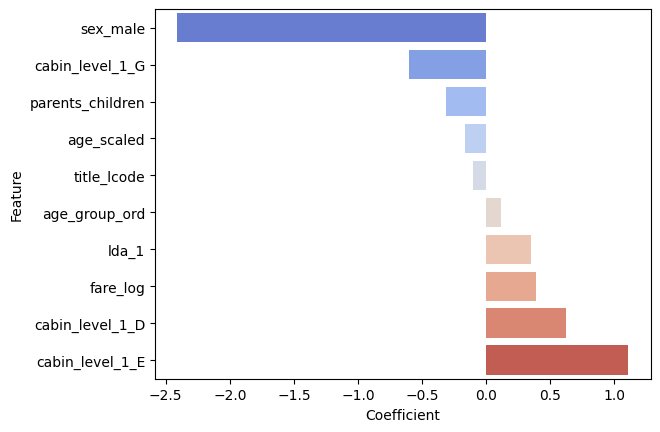

In [192]:
coefficients_df = pd.DataFrame(
    {"Feature": best_model.feature_names_in_, "Coefficient": best_model.coef_.flatten()}
)

sns.barplot(
    x="Coefficient",
    y="Feature",
    data=coefficients_df.sort_values("Coefficient"),
    palette="coolwarm",
)

## **Model & Prediction Export**

In [193]:
os.chdir(MODELS_DIR)
# Save model
joblib.dump(best_model, "lda-partial-model.joblib")
joblib.dump(lda, "lda-partial-transformer.joblib")
# Save predictions
y_predicted_df.to_parquet("lda-partial-y_predicted.parquet")